# Iterative Learning: GoodNotes Layout Detector

This notebook trains and evaluates a YOLO-based layout detector on your annotated dataset (`dataset_new`).
- Exports YOLO format from `annotations.json`
- Trains YOLO (Ultralytics)
- Evaluates on validation split and logs metrics per attempt
- Visualizes predictions

Prereqs (run in a terminal or install cell below):
- `pip install ultralytics ipywidgets ipympl matplotlib numpy pillow opencv-python-headless pymupdf`



In [ ]:
# Setup & paths (relative to repo root)
import os, json, random, shutil
from typing import List, Dict, Any
from IPython.display import display

PROJECT_ROOT = os.path.abspath(os.getcwd())
STUDY_KB_DIR = os.path.join(PROJECT_ROOT, "study_kb")
DATASET_ROOT = os.path.join(STUDY_KB_DIR, "dataset")
ANN_PATH = os.path.join(DATASET_ROOT, "annotations.json")
YOLO_DIR = os.path.join(DATASET_ROOT, "yolo_iter")
SPLIT_FILE = os.path.join(DATASET_ROOT, "split.json")
LOG_DIR = os.path.join(DATASET_ROOT, "runs_log")
os.makedirs(LOG_DIR, exist_ok=True)

# Class list must match labeling
CLASSES = [
    "handwriting_paragraph",
    "handwriting_explanatory",
    "handwriting_drawing",
    "inserted_image",
    "formula",
    "heading",
]

print("Dataset:", DATASET_ROOT)
assert os.path.exists(ANN_PATH), "annotations.json not found"


Dataset: /Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/study_kb/dataset_new


In [ ]:
# Create/refresh YOLO dataset from annotations.json and make a document-level split

def load_db() -> List[Dict[str, Any]]:
    with open(ANN_PATH, 'r') as f:
        raw = json.load(f)
    # Deduplicate by (source_pdf,page_idx) when available; else by image
    def key_for(rec: dict) -> tuple:
        sp = rec.get('source_pdf'); pi = rec.get('page_idx')
        if sp is not None and pi is not None:
            return (sp, int(pi))
        return (rec.get('image',''), -1)
    seen = set(); db = []
    for rec in raw:
        k = key_for(rec)
        if k in seen:
            continue
        seen.add(k)
        db.append(rec)
    return db


def make_split(db: List[Dict[str, Any]], seed: int = 42):
    # Group by document (prefer source_pdf; fallback to image stem before "__p")
    def doc_id(rec: Dict[str, Any]) -> str:
        sp = rec.get('source_pdf')
        if sp:
            return sp
        base = os.path.basename(rec['image'])
        stem = os.path.splitext(base)[0]
        return '__'.join(stem.split('__')[:2])

    docs = {}
    for r in db:
        d = doc_id(r)
        docs.setdefault(d, []).append(os.path.basename(r['image']))

    rng = random.Random(seed)
    doc_list = list(docs.keys())
    rng.shuffle(doc_list)
    n = len(doc_list)
    n_train = max(1, int(n*0.8))
    n_val = max(1, int(n*0.1)) if n >= 3 else 1
    train_docs = set(doc_list[:n_train])
    val_docs = set(doc_list[n_train:n_train+n_val])
    test_docs = set(doc_list[n_train+n_val:])

    split = {'train': [], 'val': [], 'test': []}
    for d, imgs in docs.items():
        if d in train_docs:
            split['train'].extend(imgs)
        elif d in val_docs:
            split['val'].extend(imgs)
        else:
            split['test'].extend(imgs)

    with open(SPLIT_FILE, 'w') as f:
        json.dump(split, f, indent=2)
    print('Split saved (doc-level):', {k: len(v) for k,v in split.items()})
    return split


def export_yolo(db: List[Dict[str, Any]], split: Dict[str, List[str]]):
    # Clean
    if os.path.exists(YOLO_DIR):
        shutil.rmtree(YOLO_DIR)
    os.makedirs(YOLO_DIR, exist_ok=True)
    for sub in ['train', 'val', 'test']:
        os.makedirs(os.path.join(YOLO_DIR, 'images', sub), exist_ok=True)
        os.makedirs(os.path.join(YOLO_DIR, 'labels', sub), exist_ok=True)

    # Build a map for quick lookup
    img_to_rec = {os.path.basename(r['image']): r for r in db}

    for sub in ['train', 'val', 'test']:
        for base in split[sub]:
            rec = img_to_rec.get(base)
            if not rec:
                continue
            src_img = rec['image']
            dst_img = os.path.join(YOLO_DIR, 'images', sub, base)
            try:
                shutil.copy2(src_img, dst_img)
            except Exception:
                continue
            w, h = rec['width'], rec['height']
            lines = []
            for a in rec['annotations']:
                cls_old = int(a['category_id'])
                if cls_old >= len(CLASSES):
                    continue
                cls = cls_old
                x0,y0,x1,y1 = a['bbox']
                bw, bh = x1-x0, y1-y0
                cx, cy = x0 + bw/2.0, y0 + bh/2.0
                cx_n, cy_n = cx / w, cy / h
                bw_n, bh_n = bw / w, bh / h
                lines.append(f"{cls} {cx_n:.6f} {cy_n:.6f} {bw_n:.6f} {bh_n:.6f}")
            with open(os.path.join(YOLO_DIR, 'labels', sub, os.path.splitext(base)[0]+'.txt'), 'w') as f:
                f.write('\n'.join(lines))
    # data.yaml
    data_yaml = os.path.join(YOLO_DIR, 'data.yaml')
    with open(data_yaml, 'w') as f:
        f.write(f"path: {YOLO_DIR}\n")
        f.write("train: images/train\nval: images/val\ntest: images/test\n")
        f.write(f"names: {CLASSES}\n")
    print('YOLO export done at', YOLO_DIR)
    return os.path.join(YOLO_DIR, 'data.yaml')

# Run once now
_db = load_db()
_split = make_split(_db)
DATA_YAML = export_yolo(_db, _split)
print('data.yaml:', DATA_YAML)


Split saved: {'train': ['Lectures.pdf__p8.png', 'Lectures.pdf__p3.png', 'Lectures.pdf__p2.png', 'Lectures.pdf__p20.png', 'Lectures.pdf__p12.png', 'Lectures.pdf__p6.png', 'Lectures.pdf__p21.png', 'Lectures.pdf__p7.png'], 'val': ['Lectures.pdf__p0.png'], 'test': ['Lectures.pdf__p5.png']}
YOLO export done at /Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/study_kb/dataset_new/yolo_iter
data.yaml: /Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/study_kb/dataset_new/yolo_iter/data.yaml


In [14]:
# Train YOLO (Ultralytics)
from ultralytics import YOLO
import time, csv, torch

RUNS_CSV = os.path.join(LOG_DIR, 'runs.csv')
if not os.path.exists(RUNS_CSV):
    with open(RUNS_CSV, 'w', newline='') as f:
        csv.writer(f).writerow(['ts','model','epochs','imgsz','train_size','val_size','map50','map50_95','run_dir'])

# Configs for quick baseline; adjust as needed
EPOCHS = 50
IMGSZ = 1024
MODEL = 'yolov8n.pt'   # small baseline; later try yolov8s/8m or RT-DETR

# Robust device selection (CPU fallback)
if torch.cuda.is_available():
    DEVICE = '0'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'

model = YOLO(MODEL)
start = time.time()
result = model.train(data=DATA_YAML, epochs=EPOCHS, imgsz=IMGSZ, device=DEVICE)
end = time.time()

# Evaluate
metrics = model.val(device=DEVICE)
map50 = float(metrics.box.map50)
map5095 = float(metrics.box.map)
run_dir = model.trainer.save_dir

with open(SPLIT_FILE, 'r') as f:
    split = json.load(f)

with open(RUNS_CSV, 'a', newline='') as f:
    csv.writer(f).writerow([
        int(start), MODEL, EPOCHS, IMGSZ, len(split['train']), len(split['val']), map50, map5095, run_dir
    ])

print('Run saved to:', run_dir)
print('Device:', DEVICE)
print('mAP@.5 =', map50, '| mAP@.5:.95 =', map5095, '| time =', round(end-start,1),'s')


New https://pypi.org/project/ultralytics/8.3.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.219 🚀 Python-3.9.6 torch-2.8.0 MPS (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/study_kb/dataset_new/yolo_iter/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tr

RuntimeError: shape mismatch: value tensor of shape [84573] cannot be broadcast to indexing result of shape [70257]

In [ ]:
%matplotlib inline

== TRAIN ==
handwriting_explanatory inst=  65  imgs=  6/6
formula                inst=  52  imgs=  6/6
handwriting_paragraph  inst=  20  imgs=  6/6
handwriting_drawing    inst=  19  imgs=  4/6
heading                inst=   9  imgs=  4/6
inserted_image         inst=   7  imgs=  3/6

== VAL ==
formula                inst=  12  imgs=  1/1
handwriting_explanatory inst=   9  imgs=  1/1
handwriting_paragraph  inst=   0  imgs=  0/1
handwriting_drawing    inst=   0  imgs=  0/1
inserted_image         inst=   0  imgs=  0/1
heading                inst=   0  imgs=  0/1

== TEST ==
formula                inst=  13  imgs=  2/2
handwriting_drawing    inst=   5  imgs=  2/2
handwriting_paragraph  inst=   4  imgs=  2/2
inserted_image         inst=   2  imgs=  1/2
heading                inst=   1  imgs=  1/2
handwriting_explanatory inst=   0  imgs=  0/2



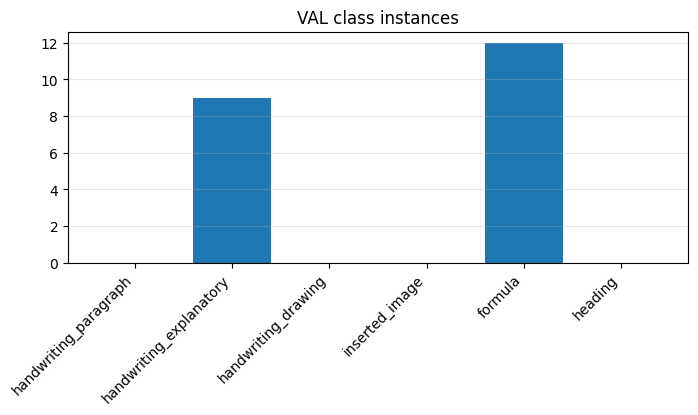

== VAL aggregate ==
mAP50=0.1257  mAP50-95=0.0518

== VAL per-class (NaN means not available) ==
class                       P      R     F1   AP50-95
handwriting_paragraph   0.125  0.778  0.215     0.052
handwriting_explanatory  0.067  0.167  0.095     0.094
handwriting_drawing       nan    nan    nan     0.052
inserted_image            nan    nan    nan     0.052
formula                   nan    nan    nan     0.009
heading                   nan    nan    nan     0.052


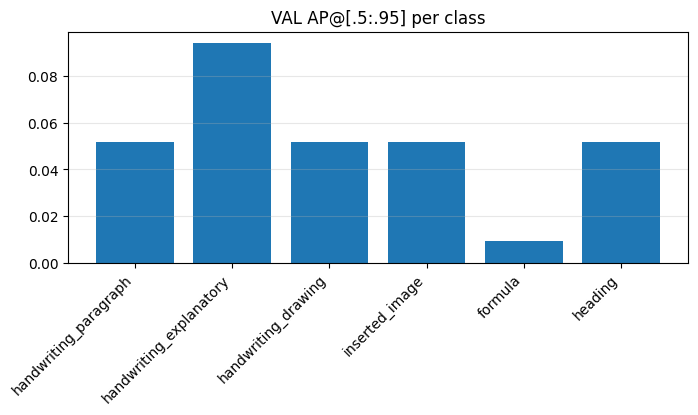

Stats ready.


In [ ]:
# Split stats and per-class metrics (to guide annotation)
import os, glob, math
from collections import Counter, defaultdict
from IPython.display import display
import matplotlib.pyplot as plt

# 1) Class balance per split from YOLO labels

def class_balance(yolo_dir: str, classes: list[str]):
    stats = {}
    for split in ['train', 'val', 'test']:
        label_files = glob.glob(os.path.join(yolo_dir, 'labels', split, '*.txt'))
        per_class_instances: Counter = Counter()
        per_class_images: defaultdict = defaultdict(int)
        total_images = len(label_files)
        for lf in label_files:
            seen_in_img = set()
            try:
                with open(lf, 'r') as f:
                    lines = [ln.strip() for ln in f if ln.strip()]
            except Exception:
                lines = []
            for ln in lines:
                parts = ln.split()
                if not parts:
                    continue
                try:
                    cid = int(float(parts[0]))
                except Exception:
                    continue
                per_class_instances[cid] += 1
                seen_in_img.add(cid)
            for cid in seen_in_img:
                per_class_images[cid] += 1
        rows = []
        for cid, name in enumerate(classes):
            rows.append({
                'class_id': cid,
                'class_name': name,
                'instances': int(per_class_instances.get(cid, 0)),
                'images_with_class': int(per_class_images.get(cid, 0)),
                'total_images': int(total_images),
            })
        stats[split] = rows
    return stats

stats = class_balance(YOLO_DIR, CLASSES)
for split, rows in stats.items():
    print(f"== {split.upper()} ==")
    rows_sorted = sorted(rows, key=lambda r: r['instances'], reverse=True)
    for r in rows_sorted:
        print(f"{r['class_name']:<22} inst={r['instances']:>4}  imgs={r['images_with_class']:>3}/{r['total_images']}")
    print()

# Optional: bar plot for VAL distribution
val_rows = stats.get('val', [])
if val_rows:
    fig, ax = plt.subplots(figsize=(8, 3))
    names = [r['class_name'] for r in val_rows]
    vals = [r['instances'] for r in val_rows]
    ax.bar(range(len(names)), vals)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_title('VAL class instances')
    ax.grid(True, axis='y', alpha=0.3)
    display(fig)
    plt.close(fig)

# 2) Per-class metrics from validation (precision/recall/F1/AP)
# Reuse metrics from prior cell when available, else run a quick val
try:
    m = metrics  # from training cell
    _ = m.box.map50  # touch to ensure structure is present
except Exception:
    from ultralytics import YOLO
    # use best weights from latest run
    try:
        rd
    except NameError:
        rd = run_dir if 'run_dir' in globals() else None
    if not rd:
        root_runs = os.path.join(os.path.dirname(DATASET_ROOT), 'runs', 'detect')
        subdirs = [os.path.join(root_runs, d) for d in os.listdir(root_runs) if os.path.isdir(os.path.join(root_runs, d))]
        rd = max(subdirs, key=os.path.getmtime)
    best_w = os.path.join(rd, 'weights', 'best.pt')
    model_tmp = YOLO(best_w)
    try:
        m = model_tmp.val(data=DATA_YAML, device='cpu', verbose=False)
    except Exception:
        m = None

if m is None:
    print('Validation metrics unavailable.')
else:
    names = CLASSES
    # Try to read arrays exposed by Ultralytics metrics
    P = getattr(m.box, 'p', None)  # precision per class
    R = getattr(m.box, 'r', None)  # recall per class
    F1 = getattr(m.box, 'f1', None)  # f1 per class
    maps = getattr(m.box, 'maps', None)  # AP@[.5:.95] per class
    map50_all = getattr(m.box, 'map50', None)
    map_all = getattr(m.box, 'map', None)

    print('== VAL aggregate ==')
    if map50_all is not None and map_all is not None:
        print(f"mAP50={float(map50_all):.4f}  mAP50-95={float(map_all):.4f}")
    print()

    # Compose per-class table
    n = len(names)
    def safe_arr(x, fill=math.nan):
        try:
            return list(x) if hasattr(x, '__len__') else [fill]*n
        except Exception:
            return [fill]*n
    P = safe_arr(P)
    R = safe_arr(R)
    F1 = safe_arr(F1)
    maps = safe_arr(maps)

    print('== VAL per-class (NaN means not available) ==')
    header = f"{'class':<22} {'P':>6} {'R':>6} {'F1':>6} {'AP50-95':>9}"
    print(header)
    for i, cname in enumerate(names):
        p = P[i] if i < len(P) else math.nan
        r = R[i] if i < len(R) else math.nan
        f1 = F1[i] if i < len(F1) else math.nan
        ap = maps[i] if i < len(maps) else math.nan
        def fmt(v):
            try:
                return f"{float(v):.3f}"
            except Exception:
                return '  NaN'
        print(f"{cname:<22} {fmt(p):>6} {fmt(r):>6} {fmt(f1):>6} {fmt(ap):>9}")

    # Optional: bar chart of AP by class if available
    if all(isinstance(v, (int, float)) and not math.isnan(v) for v in maps):
        fig2, ax2 = plt.subplots(figsize=(8, 3))
        ax2.bar(range(n), maps)
        ax2.set_xticks(range(n))
        ax2.set_xticklabels(names, rotation=45, ha='right')
        ax2.set_title('VAL AP@[.5:.95] per class')
        ax2.grid(True, axis='y', alpha=0.3)
        display(fig2)
        plt.close(fig2)

print('Stats ready.')


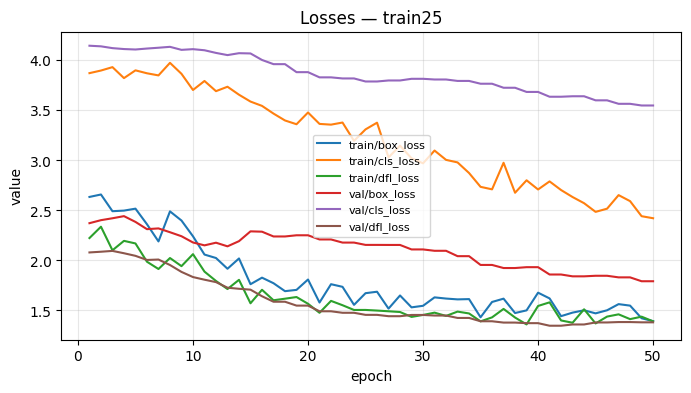

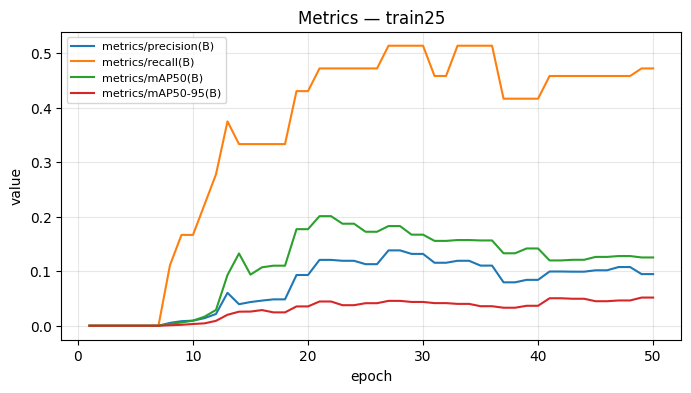

Plotted from: /Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/study_kb/runs/detect/train25/results.csv


In [ ]:
# Plot training losses and validation metrics from latest Ultralytics run
import os, csv, math
import matplotlib.pyplot as plt
from IPython.display import display

# Resolve latest run directory
try:
    rd = run_dir  # from the training cell above
except NameError:
    # Fallback: pick the newest directory from runs/detect
    root_runs = os.path.join(os.path.dirname(DATASET_ROOT), 'runs', 'detect')
    if not os.path.isdir(root_runs):
        raise FileNotFoundError(f"Runs directory not found: {root_runs}")
    subdirs = [os.path.join(root_runs, d) for d in os.listdir(root_runs) if os.path.isdir(os.path.join(root_runs, d))]
    if not subdirs:
        raise FileNotFoundError(f"No run subdirectories in: {root_runs}")
    rd = max(subdirs, key=os.path.getmtime)

results_csv = os.path.join(rd, 'results.csv')
if not os.path.exists(results_csv):
    raise FileNotFoundError(f"results.csv not found in: {rd}")

# Read CSV
rows = []
with open(results_csv, 'r', newline='') as f:
    reader = csv.DictReader(f)
    for r in reader:
        rows.append(r)

if not rows:
    print('results.csv is empty:', results_csv)
else:
    # Collect columns
    headers = list(rows[0].keys())
    # Epoch index (fallback to row index if missing)
    epochs = [int(float(r.get('epoch', i))) for i, r in enumerate(rows)]

    # Identify keys
    loss_keys = [k for k in headers if 'loss' in k]
    metric_keys = [k for k in headers if ('metrics' in k.lower()) or ('map' in k.lower()) or ('precision' in k.lower()) or ('recall' in k.lower())]

    # Parse numeric values safely
    def parse_series(keys):
        series = {}
        for k in keys:
            vals = []
            for r in rows:
                v = r.get(k, '')
                try:
                    vals.append(float(v))
                except Exception:
                    vals.append(math.nan)
            series[k] = vals
        return series

    loss_series = parse_series(loss_keys)
    metric_series = parse_series(metric_keys)

    # Plot losses
    if loss_series:
        fig_l, ax_l = plt.subplots(1, 1, figsize=(8, 4))
        for k, vals in loss_series.items():
            ax_l.plot(epochs, vals, label=k)
        ax_l.set_title(f"Losses — {os.path.basename(rd)}")
        ax_l.set_xlabel('epoch')
        ax_l.set_ylabel('value')
        ax_l.grid(True, alpha=0.3)
        ax_l.legend(loc='best', fontsize=8)
        display(fig_l)
        plt.close(fig_l)
    else:
        print('No loss columns found in results.csv. Headers:', headers)

    # Plot metrics
    if metric_series:
        fig_m, ax_m = plt.subplots(1, 1, figsize=(8, 4))
        for k, vals in metric_series.items():
            ax_m.plot(epochs, vals, label=k)
        ax_m.set_title(f"Metrics — {os.path.basename(rd)}")
        ax_m.set_xlabel('epoch')
        ax_m.set_ylabel('value')
        ax_m.grid(True, alpha=0.3)
        ax_m.legend(loc='best', fontsize=8)
        display(fig_m)
        plt.close(fig_m)
    else:
        print('No metric columns found in results.csv. Headers:', headers)

print('Plotted from:', results_csv)


val: 1 train: 6
--- VAL ---
Lectures.pdf__p6.png pred boxes: 8


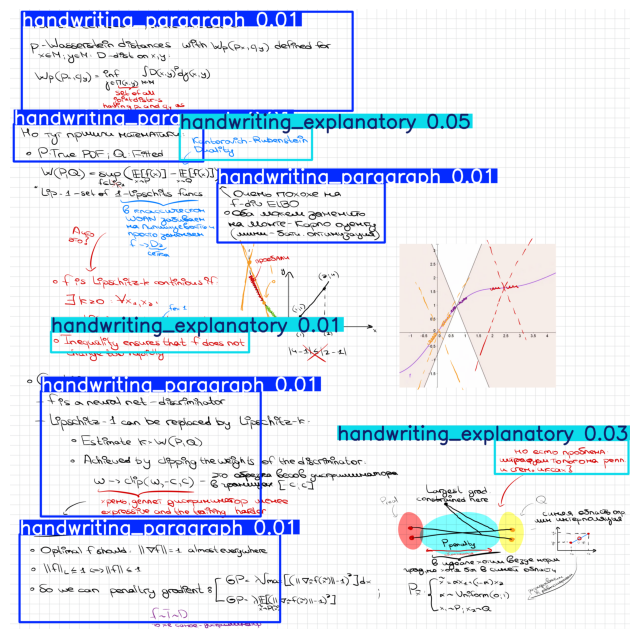

--- TRAIN ---
Lectures.pdf__p20.png pred boxes: 10


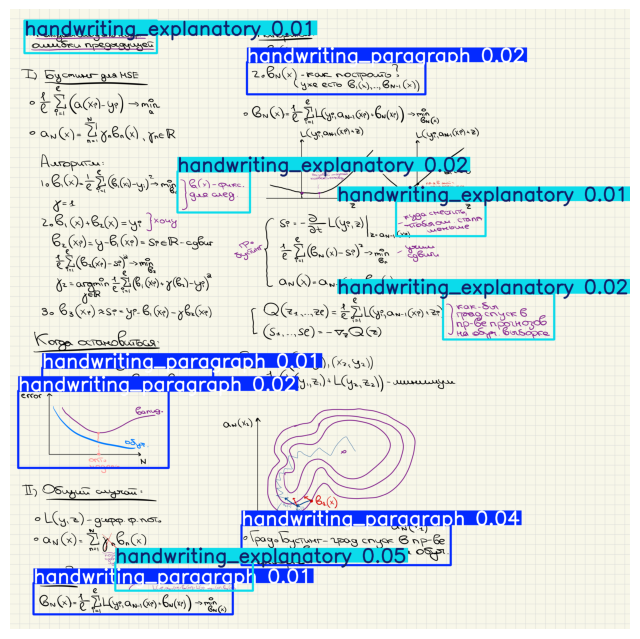

Lectures.pdf__p8.png pred boxes: 9


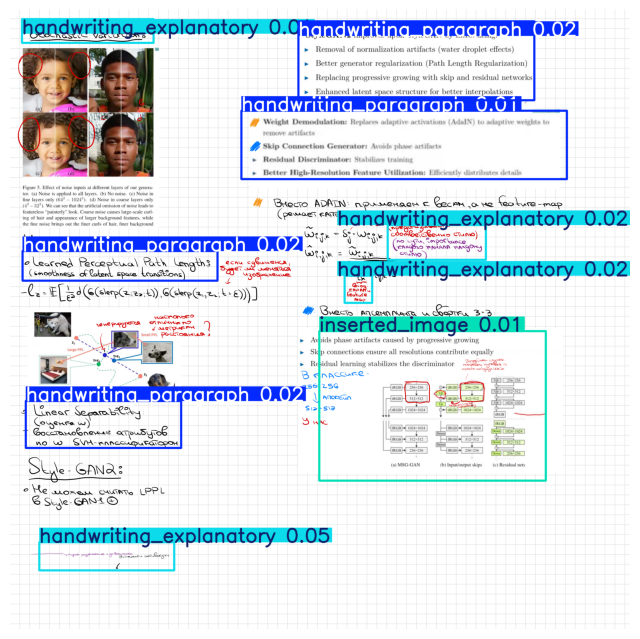

Lectures.pdf__p7.png pred boxes: 7


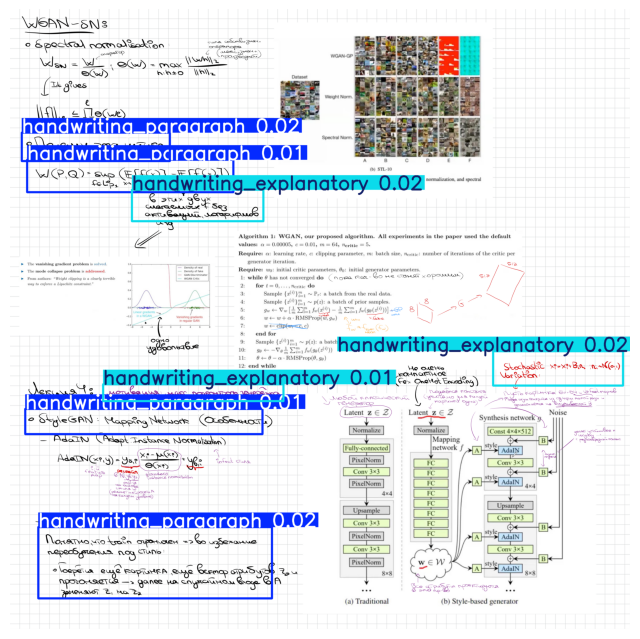

Lectures.pdf__p2.png pred boxes: 9


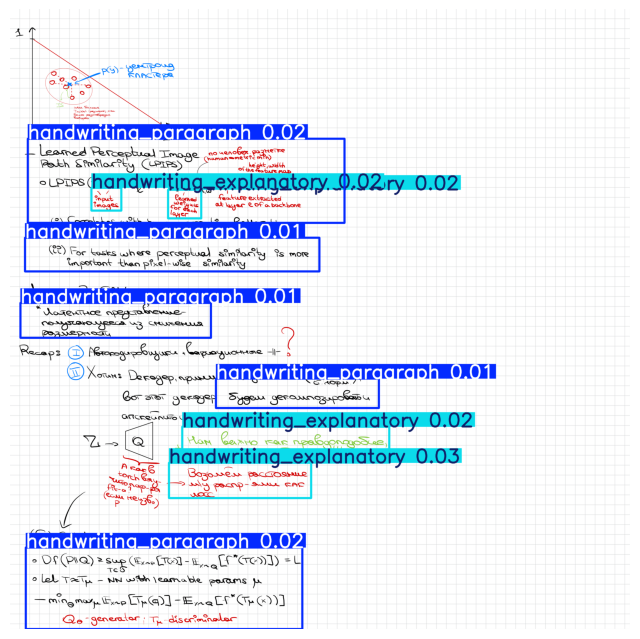

In [ ]:
from ultralytics import YOLO
from IPython.display import display
from PIL import Image
import glob, matplotlib.pyplot as plt, os, numpy as np

best = os.path.join(run_dir, 'weights', 'best.pt')
model_cpu = YOLO(best)

# 1) смотрим и val, и train, чтобы исключить проблему со сплитом
val_imgs = glob.glob(os.path.join(YOLO_DIR, 'images', 'val', '*.png')) + glob.glob(os.path.join(YOLO_DIR, 'images', 'val', '*.jpg'))
train_imgs = glob.glob(os.path.join(YOLO_DIR, 'images', 'train', '*.png')) + glob.glob(os.path.join(YOLO_DIR, 'images', 'train', '*.jpg'))
print('val:', len(val_imgs), 'train:', len(train_imgs))

def show_preds(paths, title):
    print('---', title, '---')
    for p in paths[:4]:
        res = model_cpu.predict(
            source=p, imgsz=IMGSZ, device='cpu',
            conf=0.01, iou=0.1, agnostic_nms=True, max_det=1000, verbose=False
        )
        r = res[0]
        n = 0 if r.boxes is None else r.boxes.xyxy.shape[0]
        print(os.path.basename(p), 'pred boxes:', n)
        im = Image.open(p).convert('RGB')
        # используем встроенную отрисовку
        im_bgr = r.plot()
        im_rgb = im_bgr[..., ::-1]
        fig, ax = plt.subplots(1,1, figsize=(8,10))
        ax.imshow(im_rgb)
        ax.axis('off')
        display(fig); plt.close(fig)

show_preds(val_imgs, 'VAL')
show_preds(train_imgs, 'TRAIN')